In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
import random
import pickle

random.seed(0)

f=open("BTC_USD_2018-01-01_2020-12-31-CoinDesk.csv","r")
coindesk_data=pd.read_csv(f,header=0)
seq=coindesk_data[['Closing Price (USD)','24h Open (USD)','24h High (USD)','24h Low (USD)']].to_numpy()
seq=coindesk_data[['Closing Price (USD)']].to_numpy()

n_epochs=20
batch_siz=32
n_trials=2
mode=1 # 1: experiment1(single horizon), 2: experiment2(multi horizons), 3: experiment3(effect of length of time series T)

def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(window[0]-1,len(seq)-horizon):
        for k in range(len(window)):
            x=seq[i-window[k]+1:i+1]
            y=(seq[i+horizon])
            X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

if mode==1: # sinle-step mode
    perf1,perf2,perf3,perf4=[],[],[],[]

    etime1,etime2=[],[]
    for w in range(18,21):
        for s in range(10):
            frame=[w,w]
            h=5

            X,Y=[],[]
            for i in range(frame[0],frame[1]+1):
                x,y=seq2dataset(seq,[i],h)
                X.append(x)
                Y.append(y)

            x_train,y_train=[],[]
            x_test,y_test=[],[]

            split=int(len(seq)*0.3) # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            model = Sequential()
            model.add(Conv1D(32,3,activation='relu',padding='same',input_shape=(w,1)))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(loss='mae',optimizer='adam',metrics=['mae'])

            for i in range(n_epochs):
                for j in range(len(x_train)):
                    model.train_on_batch(x_train[j],y_train[j])

                pred=[]
                for j in range(len(x_train)):
                    pred.append(model.predict(x_test[j]))

                #print(pred[0].shape);input('a')
                ave=np.mean(pred,axis=0)
                for k in range(len(pred)):
                    pred[k]=ave

                mape=np.mean(np.mean(abs(np.array(y_test)-pred)/abs(np.array(y_test)),axis=0),axis=0)

            perf1.append(mape)

            frame=[max(w-2,1),w]
            h=5

            X,Y=[],[]
            for i in range(frame[0],frame[1]+1):
                x,y=seq2dataset(seq,[i],h)
                X.append(x)
                Y.append(y)

            x_train,y_train=[],[]
            x_test,y_test=[],[]

            split=int(len(seq)*0.3) # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            pred=[]
            for j in range(len(x_train)):
                model = Sequential()
                model.add(Conv1D(32,3,activation='relu',padding='same',input_shape=(x_train[j].shape[1],1)))
                model.add(Flatten())
                model.add(Dense(1))
                model.compile(loss='mae',optimizer='adam',metrics=['mae'])

                for i in range(n_epochs):
                    model.train_on_batch(x_train[j],y_train[j])

                #pred=[]
                pred.append(model.predict(x_test[j]))

            ave=np.mean(pred,axis=0)
            for k in range(len(pred)):
                pred[k]=ave

            mape=np.mean(np.mean(abs(np.array(y_test)-pred)/abs(np.array(y_test)),axis=0),axis=0)

            perf2.append(mape)

11/11 [==============================] - 0s 2ms/step


Performance 1 (MAPE): [array([0.08996773]), array([0.13706572]), array([0.09412505]), array([0.14462178]), array([0.13785327]), array([0.14789598]), array([0.11753274]), array([0.09730042]), array([0.14621969]), array([0.16121549]), array([0.38282264]), array([0.13523268]), array([0.15091917]), array([0.12997178]), array([0.16371844]), array([0.10771558]), array([0.17737819]), array([0.1295627]), array([0.10684689]), array([0.13990445]), array([0.15623397]), array([0.16034053]), array([0.12937785]), array([0.1096376]), array([0.17059779]), array([0.22499263]), array([0.15542711]), array([0.20658976]), array([0.09916527]), array([0.12817475])]
Performance 2 (MAPE): [array([0.09981211]), array([0.10727637]), array([0.15629707]), array([0.09954524]), array([0.09441153]), array([0.14272328]), array([0.0861804]), array([0.09809965]), array([0.15954278]), array([0.11621896]), array([0.0860396]), array([0.11833476]), array([0.10815077]), array([0.12874832]), array([0.12226825]), array([0.1348

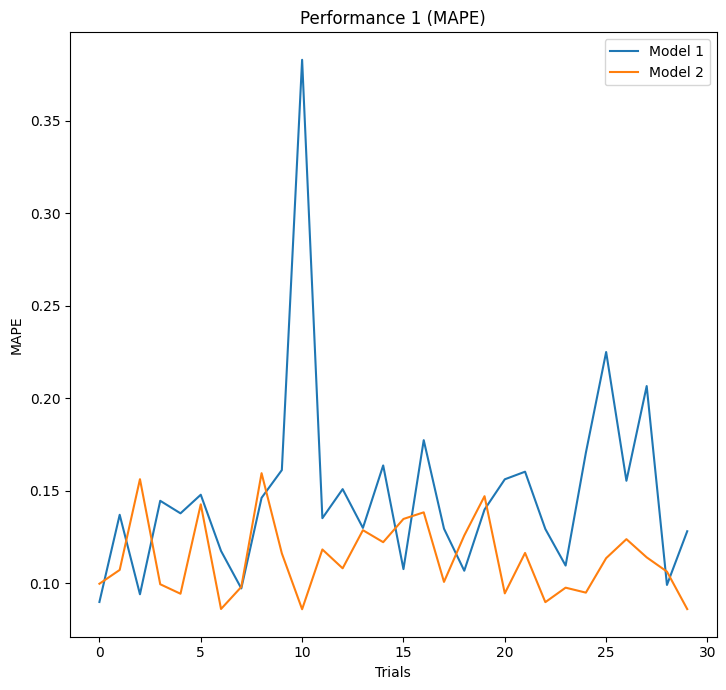

In [11]:
import matplotlib.pyplot as plt

# Print the results
print("Performance 1 (MAPE):", perf1)
print("Performance 2 (MAPE):", perf2)

# Plotting the data
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(perf1, label='Model 1')
plt.plot(perf2, label='Model 2')
plt.xlabel('Trials')
plt.ylabel('MAPE')
plt.title('Performance 1 (MAPE)')
plt.legend()

plt.tight_layout()
plt.show()